# Learning to Navigate with Gaussian Processes

Imagine you've landed a robot on a remote planet and are now trying to explore that planet to find potential life forms. The spaceship which landed your robot is still orbiting the planet and taking measurements of the elevation to enable you to navigate efficiently on the planet.

<p style="text-align:center;">
<img src='img/learning_to_plan_illustration.jpg' width="800">
</p>

# Setup

To install the required packages execute the following command in a fresh Python environment:

```bash
cd 2023_tutorials
pip install -r requirements.txt
```

If you can execute the next cell full of import statements successfully, everything should work as intended.

In [ ]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_point_clicker import clicker
%config InlineBackend.figure_formats = ['svg']
%matplotlib widget

import tueplots
from tueplots import bundles
plt.rcParams.update(bundles.neurips2022())

# Scientific computing
import numpy as np
import scipy
import probnum
import itergp
import pykeops
pykeops.set_verbose(False)

# Imports for this tutorial
from path_planning.landscapes import generate_landscape
from path_planning.dataset import Dataset
from path_planning.cost_functions import energy_cost
from path_planning.plotting import plot_path_cost

## Simulated Landscape
To give you an idea, on the left is a simulated landscape, versus the actual data you would obtain is on the right.

In [ ]:
# Simulated landscape
simulated_landscape_fn = generate_landscape(seed=42)

# Satellite measurements
num_train_data = 100000
simulated_train_data = Dataset(simulated_landscape_fn, num=num_train_data)

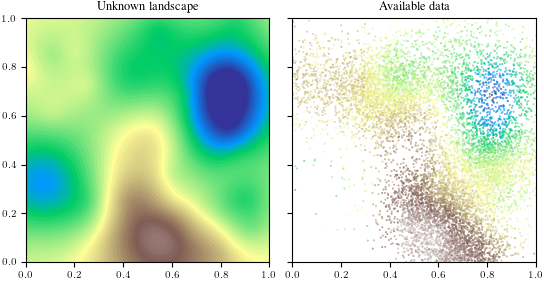

In [81]:
cmap_norm = mpl.colors.TwoSlopeNorm(vmin=-1.25, vcenter=0, vmax=1.25)

plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, axs = plt.subplots(ncols=2, sharex="row", sharey="row")

    # Plot simulated landscape
    x0s = np.linspace(0, 1.0, 100)
    x1s = np.linspace(0, 1.0, 100)
    X0, X1 = np.meshgrid(x0s, x1s)
    X_eval = np.vstack([X0.ravel(), X1.ravel()]).T
    F = simulated_landscape_fn(X_eval).reshape(X0.shape)
    axs[0].contour(X0, X1, F, levels=50, cmap="terrain", norm=cmap_norm)
    axs[0].imshow(
        F,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm
    )

    # Simulated landscape data
    n_subset = np.minimum(10000, num_train_data) # Subset training data for plot
    axs[1].scatter(simulated_train_data.X[0:n_subset, 0], simulated_train_data.X[0:n_subset, 1], c=simulated_train_data.y[0:n_subset], cmap="terrain", s=0.1)

    # Plot settings
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    axs[0].set(title="Unknown landscape")
    axs[1].set(title="Available data")
    plt.show()

## Path Planning

Now to explore the remote planet we want to move with our robot to a certain location. However, we only have limited energy resources available and need to find a path that is efficient to drive along.

In [ ]:
startpoint = np.asarray([0.1, 0.1])
endpoint = np.asarray([0.9, 0.9])

You can plan two different paths in the widget below and measure their energy cost. Try to gain an intuition which paths are energy costly and which are efficient. 

*Hint:* You can add points by clicking on the corresponding path in the legend and remove points by right-clicking near the point to be removed. The endpoint is added to the path automatically later.

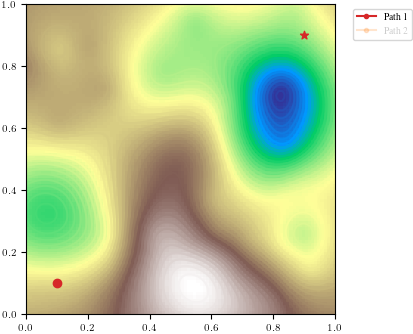

In [17]:
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, ax = plt.subplots()

    # # Landscape data
    # n_subset = np.minimum(10000, num_train_data) # Subset training data for plot
    # ax.scatter(simulated_train_data.X[0:n_subset, 0], simulated_train_data.X[0:n_subset, 1], c=simulated_train_data.y[0:n_subset], cmap="terrain", s=0.1)

    # Simulated landscape
    ax.contour(X0, X1, F, levels=50, cmap="terrain", norm=cmap_norm)
    ax.imshow(
        F, origin="lower", extent=(0.0, 1.0, 0.0, 1.0), cmap="terrain", norm=cmap_norm
    )

    # Plot start and endpoints
    ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
    ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Manual path planning
    path_list = ["Path 1", "Path 2"]
    klicker = clicker(
        ax, path_list, markers=[".", "."], colors=["C3", "C1"], linestyle="-"
    )
    klicker.set_positions({path: np.reshape(startpoint, (-1, 2)) for path in path_list})

    # Plot settings
    ax.set_aspect("equal")
    # ax.set_facecolor("black")
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    plt.show()


In [18]:
# Get paths from widget
path1 = np.unique(klicker.get_positions()["Path 1"], axis=0)
path2 = np.unique(klicker.get_positions()["Path 2"], axis=0)

print(path1)

[[0.1        0.1       ]
 [0.19991786 0.10120711]
 [0.21605131 0.14960746]
 [0.28703848 0.6336109 ]
 [0.29026517 0.49163656]
 [0.29026517 0.56907711]
 [0.29671855 0.18510104]
 [0.29671855 0.39806256]
 [0.29994524 0.34643552]
 [0.30317193 0.76590518]
 [0.30639862 0.23350139]
 [0.32253207 0.83043897]
 [0.40965269 0.91755959]
 [0.4386929  0.93691973]
 [0.48386655 0.96918663]
 [0.70650814 0.97241332]
 [0.83880241 0.96918663]
 [0.90978959 0.89819945]]


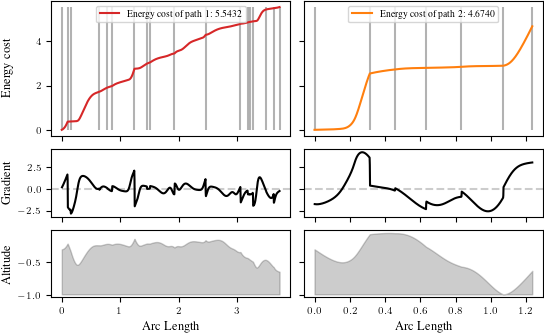

In [19]:
# Measure energy cost of moving on simulated landscape
energy_cost1 = energy_cost(path1, landscape=simulated_landscape_fn)
energy_cost2 = energy_cost(path2, landscape=simulated_landscape_fn)

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    plot_path_cost(energy_cost1, energy_cost2)

## Landscape data

Now of course in practice, we do not know the actual landscape and therefore cannot measure the energy cost of a planned path until we have actually driven to the target location. Therefore, we have *only one shot* at planning an efficient path.

In [8]:
# True landscape unknown to our robot
landscape_fn = generate_landscape(seed=17)

# Satellite measurements
num_train_data = 100000
train_data = Dataset(landscape_fn, num=num_train_data)
train_data.X.shape

(100000, 2)

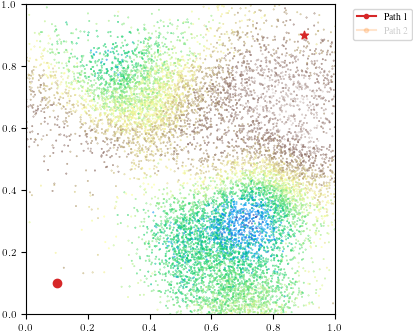

In [9]:
# Path planning using data only
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, ax = plt.subplots()

    # Landscape data
    n_subset = np.minimum(10000, num_train_data) # Subset training data for plot
    ax.scatter(train_data.X[0:n_subset, 0], train_data.X[0:n_subset, 1], c=train_data.y[0:n_subset], cmap="terrain", s=0.1, norm=cmap_norm)

    # Plot start and endpoints
    ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
    ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Manual path planning
    path_list = ["Path 1", "Path 2"]
    klicker = clicker(ax, path_list, markers=[".", "."], colors=["C3", "C1"], linestyle= "-")
    klicker.set_positions({path: np.reshape(startpoint, (-1, 2)) for path in path_list})
    
    # Plot settings
    ax.set_aspect("equal")
    # ax.set_facecolor("black")
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    plt.show()


# Learning the Landscape

Path planning is quite difficult simply from the datapoints. Let's try to learn the surface of the remote planet from the data and then plan a path based on the inferred landscape. Since we want to use energy conservatively, we need a model with uncertainty, to avoid unknown hills or valleys. We'll use a Gaussian process for this purpose.

## Gaussian Processes

From previous missions, we have a rough idea of what geological structures on the remote planet look like and how the landscape varies. We can encode this knowledge in the prior by selecting a specific kernel. We also have a rough idea of what the noise in the measurement data is from the data our satellite collects.

In [20]:
from probnum import randvars, linops
from probnum.randprocs import mean_fns
from itergp.kernels import Matern
from itergp import GaussianProcess, methods

input_shape=(2,)

# GP prior
mean_fn = mean_fns.Zero(input_shape)
kernel = Matern(input_shape, lengthscale=0.1, nu=3.5)

gp = GaussianProcess(mean_fn, kernel)

# Likelihood
sigma_sq = 0.1
noise = randvars.Normal(
    mean=np.zeros_like(train_data.y),
    cov=linops.Scaling(sigma_sq, shape=(num_train_data, num_train_data)),
)

In [21]:
from probnum import backend

x0s = np.linspace(0, 1.0, 100)
x1s = np.linspace(0, 1.0, 100)
X0, X1 = np.meshgrid(x0s, x1s)
X_eval = np.vstack([X0.ravel(), X1.ravel()]).T

samples_2D = gp.sample(backend.random.rng_state(0), X_eval, sample_shape=(5, ))


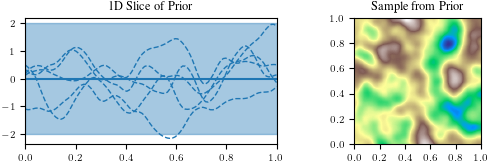

In [22]:
# Prior visualization
with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0, ncols=2)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)

    # 1D slice with samples
    X_eval_slice = np.vstack([x0s, 0.5 * np.ones_like(x0s)]).T
    gp_mean = gp.mean(X_eval_slice)
    axs[0].plot(X_eval_slice, gp_mean, color="C0")
    axs[0].fill_between(x0s, y1=gp_mean + 2 * gp.std(X_eval_slice), y2=gp_mean - 2* gp.std(X_eval_slice), color="C0", alpha=0.4)

    axs[0].set(title="1D Slice of Prior")
    axs[0].plot(x0s, samples_2D.reshape(-1, *X0.shape)[:,:, 0].T, color="C0", linestyle="--", lw=1.0)


    # Sample of prior
    axs[1].imshow(
        samples_2D.reshape(-1, *X0.shape)[0, :, :],
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm
    )
    axs[1].set(title="Sample from Prior")

    # Plot settings
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    
    plt.show()



### Vanilla GP Inference

In [105]:
from scipy.linalg import cho_factor, cho_solve

# Implement Gaussian process via Cholesky decomposition


def condition_on_data(gp_prior, X_test, X_train, y_train):
    # Kernel Gram matrix
    gram_matrix = gp_prior.cov.matrix(X_train) + sigma_sq * np.eye(X_train.shape[0])

    # Cholesky factorization
    L, is_lower = cho_factor(gram_matrix, lower=True)

    # Kernel evaluated at training data
    KXx = gp_prior.cov.matrix(X_train, X_test)

    # Posterior mean
    post_mean = gp_prior.mean(X_test) + KXx.T @ cho_solve(
        (L, is_lower), y_train - gp_prior.mean(X_train)
    )

    # Posterior covariance
    post_cov = (
        gp_prior.cov.matrix(X_test)
        - KXx.T @ cho_solve((L, is_lower), KXx)
        # + sigma_sq * np.eye(X_test.shape[0])
    )

    return post_mean, post_cov


In [24]:
# Test your implementation on a small training and test dataset

# Training data
X_train = train_data.X[0:100]
y_train = train_data.y[0:100]

# Test data
x0s = np.linspace(0, 1.0, 100)
x1s = np.linspace(0, 1.0, 100)
X0, X1 = np.meshgrid(x0s, x1s)
X_test = np.vstack([X0.ravel(), X1.ravel()]).T

post_mean, post_cov = condition_on_data(gp, X_test, X_train, y_train)

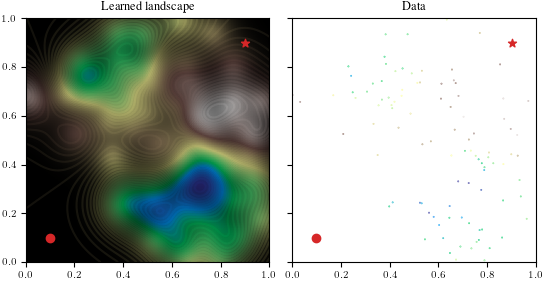

In [25]:
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, axs = plt.subplots(ncols=2, sharex="row", sharey="row")

    # Plot inferred landscape
    use_uncertainty_overlay = True

    if use_uncertainty_overlay:
        uncertainty = np.sqrt(np.diag(post_cov))
        black_background = np.full((*X0.shape, 3), 0, dtype=np.uint8)
        uncertainty_overlay = 1.0 - uncertainty.reshape(X0.shape) / np.max(uncertainty)
        axs[0].imshow(black_background)

    axs[0].contour(
        X0,
        X1,
        post_mean.reshape(X0.shape),
        levels=50,
        cmap="terrain",
        alpha=0.1,
        norm=cmap_norm,
    )
    axs[0].imshow(
        post_mean.reshape(X0.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Plot start and endpoints
    for ax in axs:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Data
    axs[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="terrain", s=0.1)

    # Plot settings
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    axs[0].set(title="Learned landscape")
    axs[1].set(title="Data")
    plt.show()


## Scaling to Large Datasets

We have a lot more data available. Can we use more of the training data to plan a better path?

In [16]:
# Now increase the training dataset size to ~100k datapoints. What happens?
X_train = train_data.X[0:100000]
y_train = train_data.y[0:100000]

post_mean, post_var = condition_on_data(gp, X_test, X_train, y_train)
# Dense kernel matrix of size n x n in memory -> 149 GiB ~= 160 GB


MemoryError: Unable to allocate 149. GiB for an array with shape (100000, 100000, 2) and data type float64

### Matrix-free Kernel Matrices

Kernel operations without memory overflow, (with autodiff and on the GPU): [KeOps](https://www.kernel-operations.io/keops/index.html).

<p style="text-align:center;">
<img src='img/keops.png' width="800">
</p>

In [ ]:
# Matrix-free representation of kernel matrix as "linear operator"
K = kernel.linop(train_data.X)

# Large-scale matrix-vector product still possible
(K @ np.ones(num_train_data)).shape

(100000,)

## Computation-Aware Inference

Accurate images on satellite around Mars, but communication with earth is slow and hardware is limited on satellite / robot. Need fast inference with little computation time. Can accept uncertainty, if path planning still is possible.

In [98]:
# Iteratively computed combined GP posterior
gp_post = gp.condition_on_data(
    train_data.X, train_data.y, noise, approx_method=methods.CG(maxiter=5)
)


In [106]:
# Marginal GP prediction on a million datapoints
x0s = np.linspace(0, 1.0, 1000)
x1s = np.linspace(0, 1.0, 1000)
X0, X1 = np.meshgrid(x0s, x1s)
X_pred = np.vstack([X0.ravel(), X1.ravel()]).T
y_pred = gp_post.mean(X_pred)
uncertainty = gp_post.std(X_pred)

In [107]:
X_pred.shape

(1000000, 2)

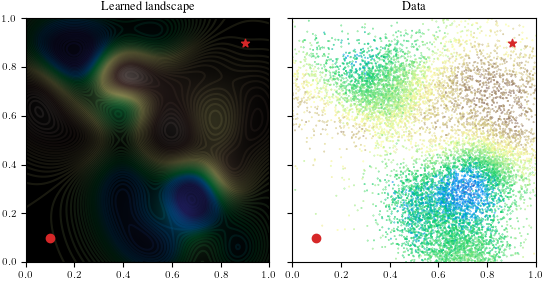

In [115]:
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, axs = plt.subplots(ncols=2, sharex="row", sharey="row")

    # Plot inferred landscape
    use_uncertainty_overlay = True

    if use_uncertainty_overlay:
        black_background = np.full((*X0.shape, 3), 0, dtype=np.uint8)
        uncertainty_overlay = 1.0 - uncertainty.reshape(X0.shape) / np.max(uncertainty)
        axs[0].imshow(black_background)

    axs[0].contour(
        X0,
        X1,
        y_pred.reshape(X0.shape),
        levels=50,
        cmap="terrain",
        alpha=0.1,
        norm=cmap_norm,
    )
    axs[0].imshow(
        y_pred.reshape(X0.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Plot start and endpoints
    for ax in axs:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Data
    n_subset = np.minimum(10000, num_train_data)  # Subset training data for plot
    axs[1].scatter(
        train_data.X[0:n_subset, 0],
        train_data.X[0:n_subset, 1],
        c=train_data.y[0:n_subset],
        cmap="terrain",
        s=0.1,
        norm=cmap_norm,
    )

    # Plot settings
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    axs[0].set(title="Learned landscape")
    axs[1].set(title="Data")
    plt.show()


In [ ]:
# TODO: Talk about uncertainty tradeoff

### Design Your Own Approximation Method

In [ ]:
# TODO: imshow part of kernel matrix and plot sparse vector

In [84]:
from typing import Optional
from probnum.backend.random import RNGState

import probnum
from probnum import backend
from probnum.linalg.solvers import ProbabilisticLinearSolver, information_ops, policies

from itergp.methods import belief_updates, stopping_criteria


class MyPolicy(policies.LinearSolverPolicy):
    def __init__(self) -> None:
        super().__init__()

    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState],
    ) -> backend.Array:
        """Return an action for a given solver state.

        Parameters
        ----------
        solver_state
            Current state of the linear solver.
        rng
            Random number generator state.

        Returns
        -------
        action
            Next action to take. Must have shape=(n,).
        """
        rng = np.random.default_rng(rng)

        # Random Gaussian actions
        # return rng.standard_normal(size=(solver_state.problem.A.shape[1],))

        # CG on subset of data
        action = np.zeros(solver_state.problem.A.shape[1])
        # action[0:2000] = solver_state.residual[0:2000]

        # CG along diagonal strip
        # idcs = np.where(np.abs(train_data.X[:, 0] - train_data.X[:, 1]) < 0.1)[0]
        # action[idcs] = solver_state.residual[idcs]

        # Use only data with altitude similar to (predicted) starting altitude to find level set
        idcs = np.where(np.abs(train_data.y - landscape_fn(startpoint)) < 0.1)[0]
        action[idcs] = solver_state.residual[idcs]

        # Only data with small gradient norm

        # Data with highest uncertainty (over gradients), etc...

        # # Store data between steps
        # if solver_state.step == 0:
        #     solver_state.cache["my_data"] = 3.0
        # else:
        #     action[solver_state.step] = solver_state.cache["my_data"]

        return action


In [85]:
class MySolver(ProbabilisticLinearSolver):

    def __init__(
        self,
        atol: float = 1e-6,
        rtol: float = 1e-6,
        maxiter: int = None,
    ):
        super().__init__(
            policy=MyPolicy(),
            information_op=information_ops.ProjectedResidualInformationOp(),
            belief_update=belief_updates.ProjectedResidualBeliefUpdate(),
            stopping_criterion=stopping_criteria.MaxIterationsStoppingCriterion(
                maxiter=maxiter,
            )
            | probnum.linalg.solvers.stopping_criteria.ResidualNormStoppingCriterion(
                atol=atol, rtol=rtol
            ),
        )

In [86]:
# Compute combined posterior 
# (uncertainty from limited data + uncertainty from limited computation)
gp_post = gp.condition_on_data(
    train_data.X, train_data.y, noise, approx_method=MySolver(maxiter=20)
)


In [ ]:
# Marginal GP prediction
y_pred = gp_post.mean(X_pred)
uncertainty = gp_post.std(X_pred)

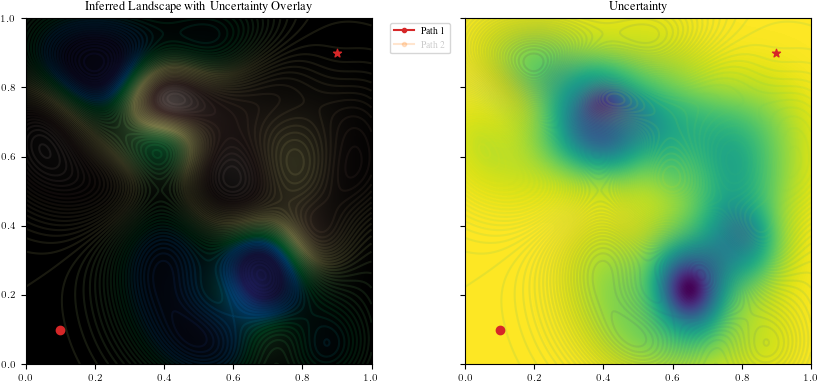

In [ ]:
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.5)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)

    # Evaluate landscape function for plotting
    use_uncertainty_overlay = True

    if use_uncertainty_overlay:
        black_background = np.full((*X0.shape, 3), 0, dtype=np.uint8)
        axs[0].imshow(black_background)
        uncertainty_overlay = 1.0 - uncertainty.reshape(X.shape)/np.max(uncertainty)

    axs[0].contour(X0, X1, y_pred.reshape(X0.shape), levels=50, cmap="terrain", alpha=0.1,norm=cmap_norm)
    axs[0].imshow(
        y_pred.reshape(X0.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm
    )

    # Uncertainty
    axs[1].contour(X0, X1, y_pred.reshape(X0.shape), levels=50, alpha=0.1)
    axs[1].imshow(
        uncertainty.reshape(X0.shape),
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
    )


    # Plot start and endpoints
    for ax in axs:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Manual path planning
    path_list = ["Path 1", "Path 2"]
    klicker = clicker(axs[0], path_list, markers=[".", "."], colors=["C3", "C1"], linestyle= "-")
    klicker.set_positions({path: np.reshape(startpoint, (-1, 2)) for path in path_list})

    # Plot settings
    axs[0].set_title("Inferred Landscape with Uncertainty Overlay" if use_uncertainty_overlay else "Inferred Landscape")
    axs[1].set_title("Uncertainty")
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[0].set_xlim(0, 1.0)
    axs[0].set_ylim(0, 1.0)
    plt.show()


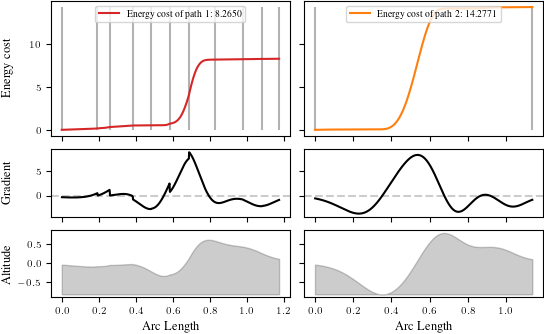

In [ ]:
# Get paths from widget
path1 = np.unique(klicker.get_positions()["Path 1"], axis=0)
path2 = np.unique(klicker.get_positions()["Path 2"], axis=0)

# Predict energy cost of based on GP
energy_cost1 = energy_cost(path1, landscape=gp_post.mean)
energy_cost2 = energy_cost(path2, landscape=gp_post.mean)

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    plot_path_cost(energy_cost1, energy_cost2)

In [ ]:
# TODO: Use clicker to let people choose observation points (and their weighing through an array later on)?
# TODO: Plot gradient vector field to choose path?



# Final Results

Let's see how good the path is you've chosen based on the learned landscape. Compare with the people sitting next to you who found the path with the least energy cost!

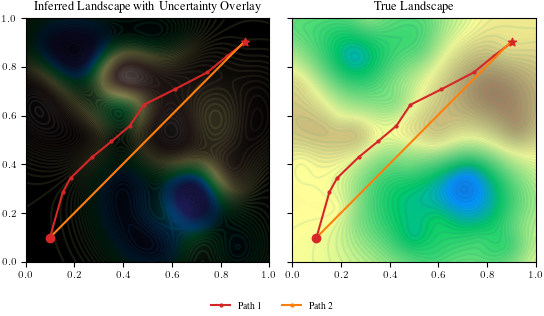

In [103]:
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)

    # Inferred landscape with uncertainty overlay
    axs[0].imshow(black_background)
    axs[0].contour(
        X0,
        X1,
        y_pred.reshape(X0.shape),
        levels=50,
        cmap="terrain",
        alpha=0.1,
        norm=cmap_norm,
    )
    axs[0].imshow(
        y_pred.reshape(X0.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Actual landscape
    y_true = landscape_fn(X_pred)
    axs[1].contour(X0, X1, y_true.reshape(X0.shape), levels=50, alpha=0.1, norm=cmap_norm)
    axs[1].imshow(
        y_true.reshape(X0.shape),
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Plot start and endpoints
    for ax in axs[0:2]:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Plot paths
    for ax in axs[0:2]:
        ax.plot(
            path1[:, 0], path1[:, 1], "-o", markersize=2, color="C3", label="Path 1"
        )
        ax.plot(
            path2[:, 0], path2[:, 1], "-o", markersize=2, color="C1", label="Path 2"
        )

    # Plot settings
    axs[0].set_title(
        "Inferred Landscape with Uncertainty Overlay"
        if use_uncertainty_overlay
        else "Inferred Landscape"
    )
    axs[1].set_title("True Landscape")
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[0].set_xlim(0, 1.0)
    axs[0].set_ylim(0, 1.0)

    # Legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles=handles,
        labels=labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.05),
        fancybox=False,
        shadow=False,
        ncol=2,
        frameon=False,
    )

    plt.show()


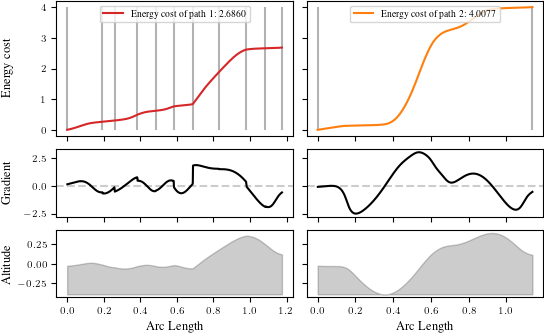

In [104]:
# Measure energy cost of moving on actual landscape
energy_cost1 = energy_cost(path1, landscape=landscape_fn)
energy_cost2 = energy_cost(path2, landscape=landscape_fn)

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    plot_path_cost(energy_cost1, energy_cost2)

# Conclusion

## Takeaways
- GPs are not expensive if we pay attention to the numerics
  - train on >100k datapoints on CPU with small memory
  - predict on >1m datapoints
- GPs allow us to trade off resources for uncertainty exactly and explicitly
- Limited data and limited compute induce uncertainty

## Extensions?
- Predict gradient vector field with GP in closed form
- Actively collect / compute on data based on a driven segment
- belief over energy cost / elevation via GP
- ... student's ideas?

# References

Libraries:
- ProbNum 
- IterGP
- KeOps

Papers:
- Posterior and Computational Uncertainty
- BayesCG
- KeOps
- GPyTorch?